<a href="https://colab.research.google.com/github/driimus/380ct/blob/master/Investigating%2BTSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Guide Notebook for the 380CT Assignment on TSP</center></h1>

_Kamal Bentahar_

[https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance](https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance)

# Notation and definitions

Let $G$ be a complete weighted graph with $n$ vertices...

- **Complete**: the graph is undirected, has no self-loops, and each node is connected to all the other vertices.
- **Weighted**: the edges have a weight (a positive integer).
- **Cycle**: a path that visits every vertex once, and goes back to the start point.
- **Total cost of the cycle**: sum of the edge weights of the cycle.

# Definition of the problem

Given $G$ as above, the versions of the TSP are defined as follows:

* **Decisional TSP (D-TSP)**:
> Given a total cost $k$, decide if $G$ is has a cycle of length $\leq k$.

    **NP-complete**, because D-TSP $\in$ NP and D-TSP $\leq_p$ HAMCYCLE.
    
    * D-TSP $\in$ NP: once a cycle is given (a certificate) we can quickly evaluate the its cost in $O(n)$ time to verify it is equal to $k$.
    * D-TSP $\leq_p$ HAMCYCLE: Reduction from HAMCYCLE (Hoos and Stutzler, p.25).

* **Search TSP**:
> Given a total cost $k$, search for a cycle of length $\leq k$ in $G$.
> (If found then return it, otherwise say that there is no such cycle.)
    
* **Optimization TSP**:
> Given $G$, find a cycle of minimal total cost.

    **NP-Hard**, because the optimization version of (decision) NP-complete problems are automatically NP-Hard. (using the same method sketched above for **Search TSP**)

The facts about the complexity classes memberships can also be found in (Garey and Johnson, 1979) and (Hoos and Stutzler, 2005).

# Testing methodology

* **Exact methods**:
    Average time for instances with increasing $n$.

* **Greedy and meta-heuristics**:
    Average "quality" as $n$ increases.


## Random instances sampling strategy

General TSP instances will be generated by creating symmetric adjacency matrices uniformly at random.

# Code

First start by importing relevant libraries.

In [0]:
from random import randint, choice
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from time      import time
import matplotlib.pyplot as plt
import copy

## Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

Without loss of generality, we can consider $0$ to be the start and end point of cycles.

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    avg_dist = 0
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            avg_dist += v
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix, avg_dist/n

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        # a = cycle[i]
        # b = cycle[(i+1)%n]
        c += G[cycle[i]][cycle[i-1]]
    return c

### Example

In [28]:
G, avg_dist = random_symmetric_graph(5)
show(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  28 466 921  60
 1 |   28   ∞ 520 467 728
 2 |  466 520   ∞ 149 626
 3 |  921 467 149   ∞ 227
 4 |   60 728 626 227   ∞



# Solution methods

## Exact methods -- Exhaustive search

The idea is to:
- Consider vertex $0$ as the start and end point.
- Iterate over all permutations of the vertices $\{1,2,\ldots, n-1\}$.
    -  Calculate cost of each permutation and keep track of minimum cost permutation.
- Return the cycle with minimum cost.

More formally, the pseudo-code is as follows:

**Input**: $G$.

**Output**: a cycle in $G$ of shortest cost.

1. $bestcycle\gets \emptyset$
2. $bestcost\gets \infty$
3. **for all** possible cycles $p$ in $G$ (starting and ending at $0$) **do**
4. $\quad$ $c\gets$ cost of $p$
2. $\quad$ **if** $c<bestcost$ **then**
3. $\qquad$ $bestcycle\gets p$
3. $\qquad$ $bestcost\gets c$
4. $\quad$ **end if**
5. **end for**
6. **return** $bestcycle, bestcost$

There are $(n-1)!$ possible cycles, and each computation of a cycle's cost costs $O(n)$. So this algorithm costs $$O((n-1)!\cdot n)=O(n!).$$

In [0]:
def exhaustive_search(G):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return (best_cycle, best_cost)

## Testing

In [30]:
pnts_n = []
pnts_t = []

n  = 8
t0 = t1 = 0

while t1-t0<1: # in seconds; if it takes too long then stop testing
    G, avg_dist = random_symmetric_graph(n)
    t0 = time()
    exhaustive_search(G)
    t1 = time()
    # record time
    print( f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0 )
    n += 1

8	0.010787010192871094
9	0.06653451919555664
10	0.6457130908966064
11	6.627811908721924


Let us plot this data to see it visually.

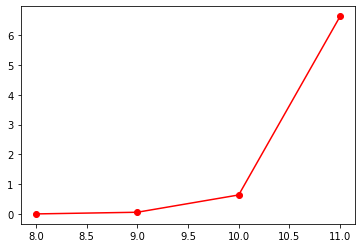

In [31]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

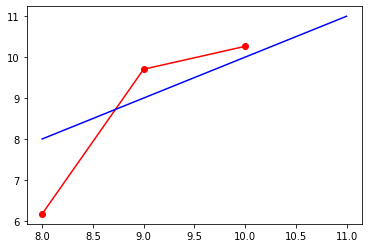

In [32]:
pnts_ratios = [pnts_t[i]/pnts_t[i-1] for i in range(1,len(pnts_n))]
plt.plot(pnts_n[:-1], pnts_ratios, 'ro-')
plt.plot(pnts_n,pnts_n,'b-') # theoretical ratios
plt.show()

### Discussion

* Exhaustive search exhibits combinatorial running time $O(n!)$:
* So it is only useful/possible when $n$ is small, up to about 13 on the current machine if it needs to finish within an hour.

# Approximation

## Greedy search

##### Nearest neigbours

In [0]:
def greedy_nearest_neighbours(G):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return (cycle, cost(G, cycle))


### Example

In [34]:
G, avg_dist = random_symmetric_graph(4)
show(G)
greedy_nearest_neighbours(G)

        0   1   2   3
    -----------------
 0 |    ∞ 223 861 444
 1 |  223   ∞ 220 716
 2 |  861 220   ∞ 185
 3 |  444 716 185   ∞



([0, 1, 2, 3], 1072)

### Test

In [41]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []
pnts_q = []

n = 10
t = 0

while t<10: # in seconds; if it takes too long then stop testing
    t = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_avgs = 0

    sum_of_distances = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        t0 = time()
        cycle, c = greedy_nearest_neighbours(G)
        t1 = time()

        sum_of_avgs += (avg_dist/2)*n
        sum_of_distances += c
        t += t1-t0
    # record time and quality
    q = (sum_of_distances/MAX_REPETITIONS)/expected_cycle_length
    q2 = sum_of_distances/sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t}\t{q}\t{q2}" )
    n *= 2

10	0.010523796081542969	0.4913	0.21503070304054203
20	0.03244376182556152	0.32850999999999997	0.06823105218010787
40	0.12215232849121094	0.19713	0.020019279969066744
80	0.46270132064819336	0.1228925	0.006158263629481919
160	1.7810301780700684	0.0749925	0.001866956609129556
320	7.1768457889556885	0.048893124999999996	0.0006070545121278827
640	30.544769287109375	0.0343809375	0.00021307222905123438


In [0]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

In [0]:
plt.plot(pnts_q, pnts_t, 'ro-')
plt.show()

## Metaheuristics

In [0]:
def twoOptSwap(cycle, i, k):
    new_cycle = cycle[:i]
    new_cycle += cycle[i:k+1][::-1]
    new_cycle += cycle[k+1:]
    return new_cycle

def iterative_improvement(G, cycle, best_distance):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    # cycle, best_distance = greedy_nearest_neighbours(H) # initial sol
    
    improved = True
    while improved:
        improved = False
        # calculate total dist for existing route 
        best_distance = cost(H, cycle)

        for i in range(0, n-2):
            improved = False
        
            for k in range(i+1, n-1):
                # new_cycle = twoOptSwap(cycle, i, k)
                new_cycle = cycle[:i] + cycle[i:k+1][::-1] + cycle[k+1:]
                new_distance = cost(H, new_cycle)
                
                if new_distance < best_distance:
                    cycle = new_cycle
                    best_distance = new_distance
                    improved = True
                    break
            
            if improved:
                break
                    
                
    return (cycle, best_distance)
    

In [0]:
G=random_symmetric_graph(5)
show(G)
cycle, best_distance = greedy_nearest_neighbours(G) # initial sol

iterative_improvement(G, cycle, best_distance)

In [0]:
MAX_REPETITIONS = 10

pnts_n = []
pnts_t = []
pnts_q = []

n = 50
t = 0
print( f"sz\titer\tNN\tQ1" )

while t < 60: # in seconds; if it takes too long then stop testing
    t = 0; t2 = 0
    # expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_distances = 0; sum_of_inits = 0
    sum_of_avgs = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        ti = time()
        cycle, best_distance = greedy_nearest_neighbours(G) # initial sol
        sum_of_inits += best_distance
        t0 = time()
        cycle, c = iterative_improvement(G, cycle, best_distance)
        t1 = time()
        sum_of_distances += c
        sum_of_avgs += (avg_dist/2)*n
        t += t1-t0
        t2 += t0 - ti
    # record time and quality
    q = sum_of_inits / sum_of_avgs
    qi = sum_of_distances / sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t: .2f}\t{t2: .2f}\t{q: .5f}\t{q2: .5f}\t{qi: .5f}\t{qi2: .5f}" )
    n += 50

sz	iter	NN	Q1
50	 0.35	 0.02	 0.01357	 0.00094	 0.00917	 0.00063
100	 3.67	 0.07	 0.00407	 0.00094	 0.00279	 0.00063
150	 15.28	 0.16	 0.00224	 0.00094	 0.00139	 0.00063


In [0]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

# References

* Garey, S. and Johnson, D. (1979)
**Computers and Intractability: A Guide to the Theory of NP-Completeness.**
Freeman.

* Hoos, H. and Stutzler, T. (2005)
**Stochastic Local Search: Foundations and Applications.**
Morgan Kaufmann.

* Sipser, M. (2013).
**Introduction to the theory of computation**
(3rd international ed.). Cengage Learning.